# Custom Metric Example

Let's make a custom metric and use it with cross-validation and `GridSearchCV`

For the sake of simplicity, let's use the iris toy dataset

## Data Preparation

In [1]:
from sklearn.datasets import load_iris

In [2]:
data = load_iris()

In [3]:
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [4]:
import pandas as pd

In [5]:
X = pd.DataFrame(data.data, columns=data.feature_names)

In [6]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [7]:
y = pd.Series(data.target)

In [8]:
y.value_counts()

2    50
1    50
0    50
dtype: int64

### Scaling

For logistic regression to converge, let's scale the data

(I didn't do this in my initial example and it created a lot of red warnings)

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()

In [11]:
X = scaler.fit_transform(X)

## Initial Modeling with Logistic Regression

We aren't doing a train-test split since this is a tiny dataset and it's difficult enough to get a recall score below 1.0. In any real modeling situation you would want to do a train-test split!

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
lr = LogisticRegression(random_state=2020, solver="liblinear")

In [14]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2020, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Model Evaluation with Already-Existing Metrics

In [15]:
lr.score(X, y)

0.9266666666666666

In [16]:
from sklearn.metrics import confusion_matrix

In [17]:
confusion_matrix(y, lr.predict(X))

array([[50,  0,  0],
       [ 0, 43,  7],
       [ 0,  4, 46]])

In [18]:
from sklearn.metrics import plot_confusion_matrix

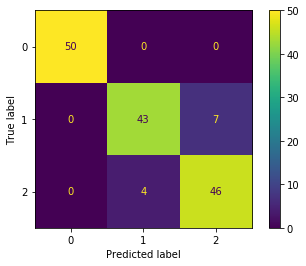

In [19]:
plot_confusion_matrix(lr, X, y);

In [20]:
from sklearn.metrics import recall_score

In [21]:
recall_score(y, lr.predict(X), average='micro')

0.9266666666666666

## Model Evaluation with a Custom Metric

Let's say we want the recall score `true_positives / (true_positives + false_negatives)`

### Basic Score Calculation

We could calculate it by hand:

In [22]:
43 / (43 + 7 + 0)

0.86

But a more robust technique would be to reuse the `recall_score` method

First, note that if we set `average=None`, it gives us an array of recall scores, one for each class:

In [23]:
recall_score(y, lr.predict(X), average=None)

array([1.  , 0.86, 0.92])

We can simply take the value at a given index, to get the recall score for that class:

In [24]:
recall_score(y, lr.predict(X), average=None)[1]

0.86

### Cross Validation

We know that a cross-validated score will represent generalization better...how to do that with our custom code?

First, put the above code into a function (with the index hard-coded):

In [25]:
def class_1_recall(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None)[1]

In [26]:
class_1_recall(y, lr.predict(X))

0.86

Then use `make_scorer` to pass your custom function into `cross_val_score`

(`make_scorer` takes 3 arguments, and actually calls the `.predict` method on the estimator. In theory we could do this without `make_scorer`, but there would be a higher possibility of making mistakes in our code, so let's just allow `make_scorer` to do the work for us.)

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [28]:
recall_scores = cross_val_score(lr, X, y, scoring=make_scorer(class_1_recall))
recall_scores

array([0.6, 0.9, 0.8, 0.7, 1. ])

In [29]:
sum(recall_scores)/len(recall_scores)

0.8

So, this tells us that our generalized class 1 recall score could be as low as 0.6, as high as 1.0.  The average of our cross-validated scores is a bit worse than the score for the dataset overall

## Grid Search

Ok, rather than just evaluating a given model's performance, let's try using this custom metric in a grid search

In [30]:
param_grid = {
    "penalty": ["l1", "l2"],
    "C": [10.0, 1.0, 0.1]
}

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
grid_lr = LogisticRegression(random_state=2020, solver="liblinear")
grid = GridSearchCV(grid_lr, param_grid, make_scorer(class_1_recall))

In [33]:
grid.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=2020, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [10.0, 1.0, 0.1], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(class_1_recall), verbose=0)

In [34]:
grid.best_estimator_

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=2020, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Grid Search Evaluation

Comparing the grid's best model's performance to our original model's performance

In [35]:
class_1_recall(y, grid.predict(X))

0.94

In [36]:
class_1_recall(y, lr.predict(X))

0.86

In [37]:
confusion_matrix(y, grid.predict(X))

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  2, 48]])

In [38]:
confusion_matrix(y, lr.predict(X))

array([[50,  0,  0],
       [ 0, 43,  7],
       [ 0,  4, 46]])

## Conclusion

Here we used a toy dataset, the iris dataset, to create an example of a custom recall metric that can be used to:

 - Describe the model's performance on the training dataset (full data or cross-validated)
 - Perform a grid search to find hyperparameters optimized for the custom metric, rather than one of the metrics built in to SciKit-Learn

Note that this example does not follow machine learning best practices; it is designed to demonstrate a custom metric with minimal code snippets